In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Initialize an empty list to store DataFrames
combined_df1 = pd.DataFrame()
combined_df2 = pd.DataFrame()

# Loop through the range of numbers
for number in range(16501, 16510):
    print("loading ", number)
    # Construct the file name
    file1_pos_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/positive-charge/recon8t_d{number}.csv'
    file2_pos_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/positive-charge/labels_d{number}.csv'
    file1_neg_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/negative-charge/recon8t_d{number}.csv'
    file2_neg_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/negative-charge/labels_d{number}.csv'
    # Read the CSV file
    df1_pos = pd.read_csv(file1_pos_name, dtype='float32')
    df2_pos = pd.read_csv(file2_pos_name, dtype='float32')
    df1_neg = pd.read_csv(file1_neg_name, dtype='float32')
    df2_neg = pd.read_csv(file2_neg_name, dtype='float32')

    df2_pos['charge'] = 1
    df2_neg['charge'] = -1

    # Concatenate all DataFrames in the list
    combined_df1 = pd.concat([combined_df1, df1_pos, df1_neg], ignore_index=True)
    combined_df2 = pd.concat([combined_df2, df2_pos, df2_neg], ignore_index=True)

loading  16501
loading  16502
loading  16503
loading  16504
loading  16505
loading  16506
loading  16507
loading  16508
loading  16509


In [3]:
import gc
print(combined_df2.describe())
X = combined_df1.values
y = combined_df2.values
del combined_df1
del combined_df2
n = X.shape[0]
print(X.shape, y.shape)
gc.collect()

             x-entry        y-entry   z-entry            n_x            n_y  \
count  217754.000000  217754.000000  217754.0  217754.000000  217754.000000   
mean        3.702606       0.109820     100.0      -0.082999      -0.003157   
std       154.415894      13.217155       0.0       4.396502       0.221343   
min      -470.813873     -38.627296     100.0     -37.436077      -1.397942   
25%       -89.459047      -9.608396     100.0      -1.571073      -0.118156   
50%         0.275258       0.115790     100.0       0.003784      -0.002779   
75%        93.698252       9.881001     100.0       1.528389       0.111412   
max       474.552917      42.305004     100.0      37.669289       1.373608   

                 n_z  number_eh_pairs        y-local             pt  \
count  217754.000000    217754.000000  217754.000000  217754.000000   
mean       -1.259827     23441.410156      -0.047857       0.003289   
std         0.815457     17402.105469       4.588600       1.516738   
min 

0

In [4]:
X_reshaped = X.reshape(-1, 8*13*21)
X = StandardScaler().fit_transform(X_reshaped)
del X_reshaped
gc.collect()
X = X.reshape(n,8,13,21)
# X = X.reshape(n,8,13,21,1)
# scaler = StandardScaler().fit(X_reshaped)
# print(scaler.mean_, scaler.scale_)
# Reshape back to original shape

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
del X
del y
gc.collect()

0

In [6]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (14, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=(1,3))
        n = y.shape[0]
        one_hot = np.zeros((n, 3))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) > 2, 0] = 1

        # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        one_hot[(np.abs(y[:, 8]) <= 2) & (y[:, 13] == 1), 1] = 1

        # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        one_hot[(np.abs(y[:, 8]) <= 2) & (y[:, 13] == -1), 2] = 1
        return np.concatenate((X_sum, y[:,7].reshape(-1, 1)), axis=1), one_hot
    else:
        raise ValueError("Wrong array shape!")


X_train, y_train = to_sum(X_train, y_train)
X_val, y_val = to_sum(X_val, y_val)
X_test, y_test = to_sum(X_test, y_test)

In [7]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets for each set
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)


batch_size = 256
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [19]:
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x






In [20]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.argmax(y_train, axis=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def one_hot_to_indices(one_hot):
    return torch.max(one_hot, 1)[1]

def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), one_hot_to_indices(labels).to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [24]:
# %pip install tqdm
from tqdm import tqdm

num_epochs = 100
best_val_accuracy = 0
patience, trials = 20, 0

# Example training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', position=0, leave=True)
    for i, data in train_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), one_hot_to_indices(labels).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_bar.set_postfix({'Train Loss': running_loss / (i + 1), 'Train Acc': 100. * correct / total})


    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    val_accuracy = calculate_accuracy(model, val_loader, device)
    print(f'\nEpoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        trials = 0
        torch.save(model.state_dict(), './best_model.pth')
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered")
            break

Note: you may need to restart the kernel to use updated packages.


Epoch 1/100: 100%|██████████| 680/680 [02:44<00:00,  4.14it/s, Train Loss=1.04, Train Acc=50.9]



Epoch 1/100, Train Loss: 1.0403, Train Accuracy: 50.87%, Validation Accuracy: 48.39%


Epoch 2/100: 100%|██████████| 680/680 [02:34<00:00,  4.39it/s, Train Loss=1.04, Train Acc=50.9]



Epoch 2/100, Train Loss: 1.0380, Train Accuracy: 50.89%, Validation Accuracy: 54.00%


Epoch 3/100: 100%|██████████| 680/680 [02:45<00:00,  4.12it/s, Train Loss=1.04, Train Acc=51.1]



Epoch 3/100, Train Loss: 1.0355, Train Accuracy: 51.14%, Validation Accuracy: 52.21%


Epoch 4/100: 100%|██████████| 680/680 [02:26<00:00,  4.63it/s, Train Loss=1.03, Train Acc=51.7]



Epoch 4/100, Train Loss: 1.0328, Train Accuracy: 51.74%, Validation Accuracy: 49.47%


Epoch 5/100: 100%|██████████| 680/680 [02:37<00:00,  4.32it/s, Train Loss=1.03, Train Acc=51.7]



Epoch 5/100, Train Loss: 1.0307, Train Accuracy: 51.69%, Validation Accuracy: 52.83%


Epoch 6/100: 100%|██████████| 680/680 [02:30<00:00,  4.50it/s, Train Loss=1.03, Train Acc=51.9]



Epoch 6/100, Train Loss: 1.0292, Train Accuracy: 51.93%, Validation Accuracy: 51.43%


Epoch 7/100: 100%|██████████| 680/680 [02:59<00:00,  3.79it/s, Train Loss=1.03, Train Acc=52.1]



Epoch 7/100, Train Loss: 1.0278, Train Accuracy: 52.10%, Validation Accuracy: 52.57%


Epoch 8/100: 100%|██████████| 680/680 [02:36<00:00,  4.34it/s, Train Loss=1.03, Train Acc=52.1]



Epoch 8/100, Train Loss: 1.0274, Train Accuracy: 52.07%, Validation Accuracy: 53.17%


Epoch 9/100: 100%|██████████| 680/680 [02:35<00:00,  4.36it/s, Train Loss=1.03, Train Acc=52.2]



Epoch 9/100, Train Loss: 1.0255, Train Accuracy: 52.20%, Validation Accuracy: 51.44%


Epoch 10/100: 100%|██████████| 680/680 [02:45<00:00,  4.12it/s, Train Loss=1.02, Train Acc=52.3]



Epoch 10/100, Train Loss: 1.0244, Train Accuracy: 52.29%, Validation Accuracy: 51.49%


Epoch 11/100: 100%|██████████| 680/680 [02:47<00:00,  4.05it/s, Train Loss=1.02, Train Acc=52.3]



Epoch 11/100, Train Loss: 1.0237, Train Accuracy: 52.32%, Validation Accuracy: 51.71%


Epoch 12/100: 100%|██████████| 680/680 [02:40<00:00,  4.24it/s, Train Loss=1.02, Train Acc=52.6]



Epoch 12/100, Train Loss: 1.0224, Train Accuracy: 52.63%, Validation Accuracy: 54.17%


Epoch 13/100: 100%|██████████| 680/680 [02:09<00:00,  5.25it/s, Train Loss=1.02, Train Acc=52.6]



Epoch 13/100, Train Loss: 1.0223, Train Accuracy: 52.57%, Validation Accuracy: 49.81%


Epoch 14/100: 100%|██████████| 680/680 [01:52<00:00,  6.03it/s, Train Loss=1.02, Train Acc=52.4] 



Epoch 14/100, Train Loss: 1.0217, Train Accuracy: 52.43%, Validation Accuracy: 51.94%


Epoch 15/100: 100%|██████████| 680/680 [02:49<00:00,  4.01it/s, Train Loss=1.02, Train Acc=52.8]



Epoch 15/100, Train Loss: 1.0206, Train Accuracy: 52.78%, Validation Accuracy: 51.59%


Epoch 16/100: 100%|██████████| 680/680 [02:44<00:00,  4.13it/s, Train Loss=1.02, Train Acc=52.4]



Epoch 16/100, Train Loss: 1.0201, Train Accuracy: 52.45%, Validation Accuracy: 53.55%


Epoch 17/100: 100%|██████████| 680/680 [02:26<00:00,  4.63it/s, Train Loss=1.02, Train Acc=52.8]



Epoch 17/100, Train Loss: 1.0193, Train Accuracy: 52.76%, Validation Accuracy: 50.72%


Epoch 18/100: 100%|██████████| 680/680 [02:29<00:00,  4.55it/s, Train Loss=1.02, Train Acc=52.8]



Epoch 18/100, Train Loss: 1.0194, Train Accuracy: 52.84%, Validation Accuracy: 51.77%


Epoch 19/100: 100%|██████████| 680/680 [02:38<00:00,  4.30it/s, Train Loss=1.02, Train Acc=52.8]



Epoch 19/100, Train Loss: 1.0183, Train Accuracy: 52.84%, Validation Accuracy: 51.79%


Epoch 20/100: 100%|██████████| 680/680 [02:44<00:00,  4.13it/s, Train Loss=1.02, Train Acc=52.7]



Epoch 20/100, Train Loss: 1.0184, Train Accuracy: 52.73%, Validation Accuracy: 52.61%


Epoch 21/100: 100%|██████████| 680/680 [02:23<00:00,  4.73it/s, Train Loss=1.02, Train Acc=53]  



Epoch 21/100, Train Loss: 1.0175, Train Accuracy: 53.04%, Validation Accuracy: 51.57%


Epoch 22/100: 100%|██████████| 680/680 [02:46<00:00,  4.09it/s, Train Loss=1.02, Train Acc=52.9]



Epoch 22/100, Train Loss: 1.0174, Train Accuracy: 52.89%, Validation Accuracy: 51.74%


Epoch 23/100: 100%|██████████| 680/680 [02:17<00:00,  4.95it/s, Train Loss=1.02, Train Acc=53]  



Epoch 23/100, Train Loss: 1.0164, Train Accuracy: 53.01%, Validation Accuracy: 52.65%


Epoch 24/100: 100%|██████████| 680/680 [02:44<00:00,  4.12it/s, Train Loss=1.02, Train Acc=53]  



Epoch 24/100, Train Loss: 1.0165, Train Accuracy: 53.02%, Validation Accuracy: 52.82%


Epoch 25/100: 100%|██████████| 680/680 [02:37<00:00,  4.33it/s, Train Loss=1.02, Train Acc=53]  



Epoch 25/100, Train Loss: 1.0158, Train Accuracy: 52.98%, Validation Accuracy: 51.82%


Epoch 26/100: 100%|██████████| 680/680 [02:31<00:00,  4.48it/s, Train Loss=1.02, Train Acc=53]  



Epoch 26/100, Train Loss: 1.0152, Train Accuracy: 53.01%, Validation Accuracy: 51.42%


Epoch 27/100: 100%|██████████| 680/680 [02:32<00:00,  4.46it/s, Train Loss=1.01, Train Acc=53.1]



Epoch 27/100, Train Loss: 1.0149, Train Accuracy: 53.08%, Validation Accuracy: 53.96%


Epoch 28/100: 100%|██████████| 680/680 [02:44<00:00,  4.13it/s, Train Loss=1.01, Train Acc=53.2]



Epoch 28/100, Train Loss: 1.0143, Train Accuracy: 53.24%, Validation Accuracy: 53.83%


Epoch 29/100: 100%|██████████| 680/680 [02:11<00:00,  5.18it/s, Train Loss=1.01, Train Acc=53.1]



Epoch 29/100, Train Loss: 1.0140, Train Accuracy: 53.10%, Validation Accuracy: 53.67%


Epoch 30/100: 100%|██████████| 680/680 [02:21<00:00,  4.81it/s, Train Loss=1.01, Train Acc=53.2]



Epoch 30/100, Train Loss: 1.0137, Train Accuracy: 53.24%, Validation Accuracy: 53.60%


Epoch 31/100: 100%|██████████| 680/680 [02:29<00:00,  4.56it/s, Train Loss=1.01, Train Acc=53.2]



Epoch 31/100, Train Loss: 1.0139, Train Accuracy: 53.24%, Validation Accuracy: 52.13%


Epoch 32/100: 100%|██████████| 680/680 [02:08<00:00,  5.30it/s, Train Loss=1.01, Train Acc=53.4] 



Epoch 32/100, Train Loss: 1.0133, Train Accuracy: 53.36%, Validation Accuracy: 54.00%
Early stopping triggered


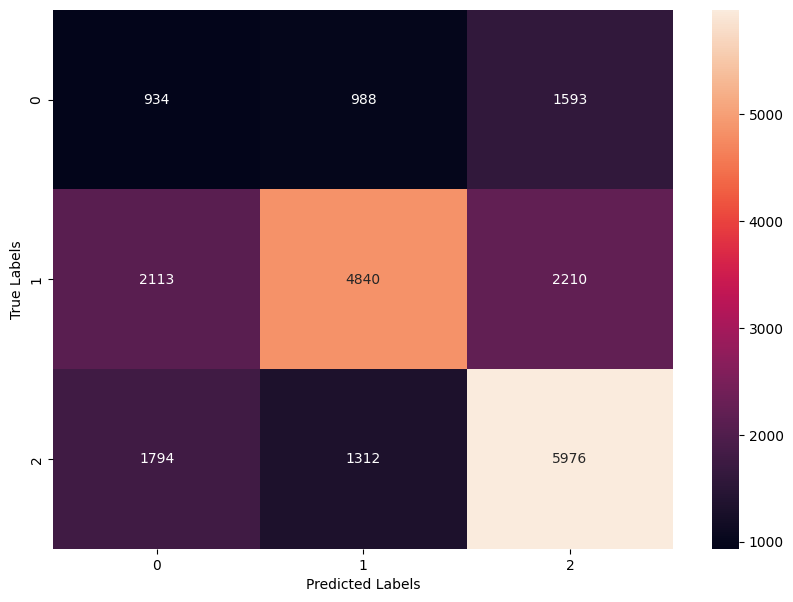

In [26]:
from sklearn.metrics import confusion_matrix
def get_all_preds_labels(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # If your labels are one-hot encoded, convert them to indices
            if labels.ndimension() > 1:
                labels = torch.argmax(labels, dim=1)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)
preds, labels = get_all_preds_labels(model, val_loader, device)
cm = confusion_matrix(labels, preds)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
TP = cm[0, 0]
FN = np.sum(cm[0, :]) - TP
TN = np.sum(np.diag(cm)) - TP
FP = np.sum(cm[:, 0]) - TP

signal_efficiency = TP / (TP + FN) if (TP + FN) != 0 else 0
background_rejection = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"Signal Efficiency: {signal_efficiency:.4f}")
print(f"Background Rejection: {background_rejection:.4f}")

Signal Efficiency: 0.2657
Background Rejection: 0.7346


In [50]:
from sklearn.metrics import roc_auc_score
state_dict = torch.load('./best_model.pth')

# Apply the state dictionary to your model
model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode

all_preds = []  # Store probabilities for class 0
all_labels = []  # Store true labels

with torch.no_grad():  # Disable gradient tracking
    for inputs, labels in test_loader:
        outputs = model(inputs)  # Get model outputs
        all_preds.extend(outputs[:, 0].cpu().numpy())  # Store probabilities for class 0
        all_labels.extend(labels[:, 0].cpu().numpy())

# Convert labels to binary (1 for class 0, 0 for others)
binary_labels = (np.array(all_labels) == 0).astype(int)
binary_labels = np.array(binary_labels).reshape(-1, 1)
all_preds = np.array(all_preds).reshape(-1, 1)
# Calculate AUC
auc_score = roc_auc_score(binary_labels, all_preds)
print(f"AUC for class 0 vs rest: {auc_score:.2f}")

AUC for class 0 vs rest: 0.43


In [51]:
thresholds = np.linspace(0, 1, num=100)  # Create a list of thresholds

signal_efficiency = []
background_rejection = []

for threshold in thresholds:
    # Apply threshold to prediction probabilities to get predicted classes
    predicted_classes = (all_preds >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(binary_labels, predicted_classes).ravel()

    # Calculate signal efficiency (True Positive Rate)
    se = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate background rejection (True Negative Rate)
    br = tn / (tn + fp) if (tn + fp) != 0 else 0

    signal_efficiency.append(se)
    background_rejection.append(br)

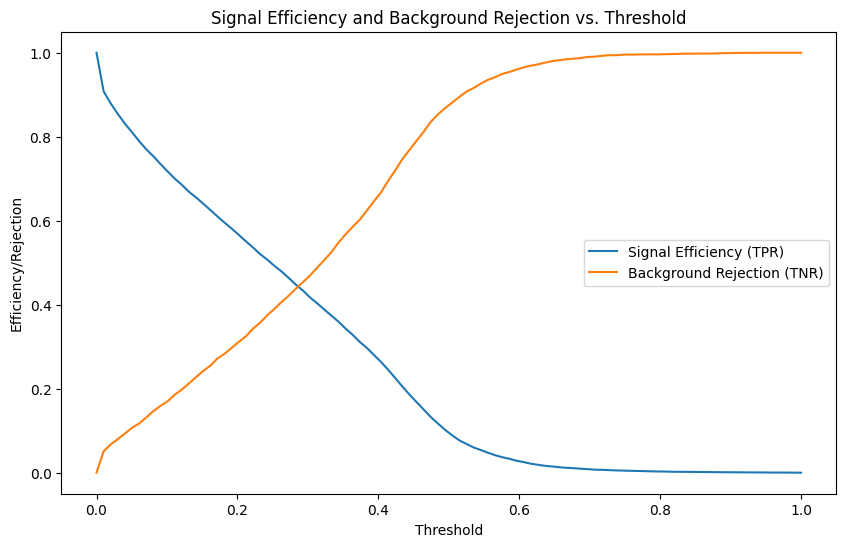

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiency, label='Signal Efficiency (TPR)')
plt.plot(thresholds, background_rejection, label='Background Rejection (TNR)')
plt.xlabel('Threshold')
plt.ylabel('Efficiency/Rejection')
plt.title('Signal Efficiency and Background Rejection vs. Threshold')
plt.legend()
plt.show()

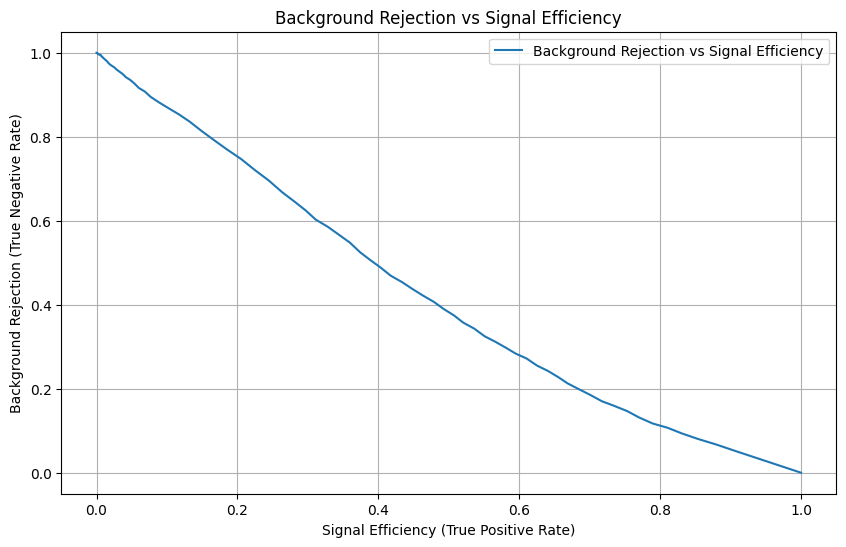

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiency, background_rejection, label='Background Rejection vs Signal Efficiency')
plt.xlabel('Signal Efficiency (True Positive Rate)')
plt.ylabel('Background Rejection (True Negative Rate)')
plt.title('Background Rejection vs Signal Efficiency')
plt.legend()
plt.grid(True)
plt.show()